#### Landsat 8 - Satellite Data Processing
This notebook will help in calculation of Landsat 8 indices and understanding the spatial join with respect to administrative boundaries.

In [2]:
import geopandas as gpd
import fiona
import gdal
from osgeo import ogr,osr
import rasterio as rio
from rasterio.mask import mask
import rasterio.features
import rasterio.warp

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

import yaml
import json

from pathlib import Path
import os

#### Defining variables

Here Zoom Level are referred to mapbox supermercado zoom which is approximately 100m 

In [3]:
ZOOM = 18
DATA  = Path('data')
RDATA = Path(f'{DATA}/raster_ip/')
VDATA = Path(f'{DATA}/vector/')

In [4]:
!tree {RDATA}

Folder PATH listing for volume Windows
Volume serial number is F4CD-4404
C:\GRAMENER APPLICATION\ETL\ETL\URBAN-HEAT-ISLAND-ETL\NOTEBOOK\DATA\RASTER_IP
ÃÄÄÄ201310
ÃÄÄÄ201311
ÃÄÄÄ201312
ÃÄÄÄ20133
ÃÄÄÄ20134
ÃÄÄÄ20135
ÃÄÄÄ20136
ÃÄÄÄ20137
ÃÄÄÄ20138
ÃÄÄÄ20139
ÃÄÄÄ20141
ÃÄÄÄ201410
ÃÄÄÄ201411
ÃÄÄÄ201412
ÃÄÄÄ20142
ÃÄÄÄ20143
ÃÄÄÄ20144
ÃÄÄÄ20145
ÃÄÄÄ20146
ÃÄÄÄ20147
ÃÄÄÄ20148
ÃÄÄÄ20149
ÃÄÄÄ201510
ÃÄÄÄ201511
ÃÄÄÄ201512
ÃÄÄÄ20152
ÃÄÄÄ20153
ÃÄÄÄ20154
ÃÄÄÄ20155
ÃÄÄÄ20156
ÃÄÄÄ20157
ÃÄÄÄ20158
ÃÄÄÄ20159
ÃÄÄÄ20161
ÃÄÄÄ201610
ÃÄÄÄ201611
ÃÄÄÄ201612
ÃÄÄÄ20162
ÃÄÄÄ20163
ÃÄÄÄ20164
ÃÄÄÄ20165
ÃÄÄÄ20166
ÃÄÄÄ20167
ÃÄÄÄ20168
ÃÄÄÄ20169
ÃÄÄÄ20171
ÃÄÄÄ201710
ÃÄÄÄ201711
ÃÄÄÄ201712
ÃÄÄÄ20172
ÃÄÄÄ20173
ÃÄÄÄ20174
ÃÄÄÄ20175
ÃÄÄÄ20176
ÃÄÄÄ20177
ÃÄÄÄ20178
ÃÄÄÄ20179
ÃÄÄÄ20181
ÃÄÄÄ201810
ÃÄÄÄ201811
ÃÄÄÄ201812
ÃÄÄÄ20182
ÃÄÄÄ20183
ÃÄÄÄ20185
ÃÄÄÄ20186
ÃÄÄÄ20187
ÃÄÄÄ20188
ÃÄÄÄ20189
ÃÄÄÄ20191
ÃÄÄÄ201910
ÃÄÄÄ201911
ÃÄÄÄ201912
ÃÄÄÄ20192
ÃÄÄÄ20193
ÃÄÄÄ20194
ÃÄÄÄ20195
ÃÄÄÄ20196
ÃÄÄÄ20197
ÃÄÄÄ20198
ÃÄÄÄ20201
ÃÄÄÄ202010
ÃÄÄÄ20202
ÃÄÄÄ202

In [5]:
!tree {VDATA}

Folder PATH listing for volume Windows
Volume serial number is F4CD-4404
C:\GRAMENER APPLICATION\ETL\ETL\URBAN-HEAT-ISLAND-ETL\NOTEBOOK\DATA\VECTOR
ÃÄÄÄ.ipynb_checkpoints
ÃÄÄÄcommunity
ÃÄÄÄcommunity_new
ÃÄÄÄdata_for_model
ÃÄÄÄinput
ÃÄÄÄintermediate
ÃÄÄÄlst_zoom20_op
ÃÄÄÄmerged_30m
ÃÄÄÄnew_iter_vector19
ÃÄÄÄoutput
ÃÄÄÄoutput_2020
ÃÄÄÄoutput_temp
ÃÄÄÄsample_zoom19
ÃÄÄÄsummer_months_all
ÃÄÄÄtrial_outputs
ÃÄÄÄzoom_19_merged
ÀÄÄÄzoom_20_op


#### Calgary Boundary

Reading algary boundary geojson file and converting it's projection to UTM for metric calculation

Find UTM zone [Here](https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#)

In [6]:
calgary_gdf = gpd.read_file(f'{VDATA}/input/calgary.geojson')
calgary_gdf = calgary_gdf.to_crs(epsg=32612)

<AxesSubplot:>

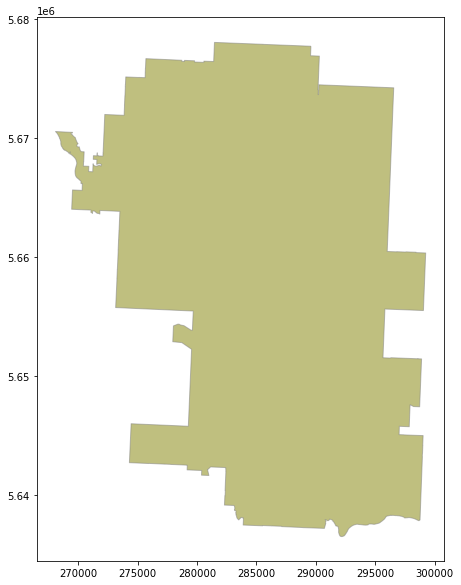

In [7]:
calgary_gdf.plot(figsize=(10, 10), color='olive', alpha=0.5, edgecolor='gray')

In [8]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [9]:
r = list_files(RDATA)

In [10]:
for i in r :
    print(i)

data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B1.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B10.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B11.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B2.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B3.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B4.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B5.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B6.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B7.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B8.TIF
data\raster_ip\201310\LC08_L1TP_042024_20131011_20170308_01_T1_B9.TIF
data\raster_ip\201311\LC08_L1TP_042024_20131112_20170307_01_T1_B1.TIF
data\raster_ip\201311\LC08_L1TP_042024_20131112_20170307_01_T1_B10.TIF
data\raster_ip\201311\LC08_L1TP_042024_20131112_20170307_01_T1_B11.TIF
data\raster_ip\2

### Clip the Raster to the specific region of interest using the boundary file

The below function will help in cropping each image of landsat to it's 

In [42]:
def clip_tile(name, bands=[2,3,4,5,6,7,10,11]):
    for band in bands:
        #print(path2 , path3)
        #print(f'Processing band: B{band}', end=" ")
        tile = f'{RDATA}/{path2}/{name}{band}.TIF'
        
        with rio.open(tile) as src:
            img, tfm = mask(src, calgary_gdf.geometry, crop=True)
            meta = src.meta
            meta.update({"driver": "GTiff",
                         "height": img.shape[1],
                         "width": img.shape[2],
                         "transform": tfm})
            print (img)
            Path(f'{DATA}/intermediate/{year_month1}/').mkdir(exist_ok=True)
            
            with rio.open(f'{DATA}/intermediate/{year_month1}/calgary_band_{band}.tif', "w", **meta) as f:
                f.write(img)
            
            #print('Done.')

In [1]:
# path_list=[]
# subfolder_list=[]
# data_list=[]

# for idx, path in enumerate(r[0:30]):
#     print(path)
#     if path.split('\\')[3].split('_')[7].split('.')[1] =='TIF':
#         path1=path.split('\\')[3]
#         #print(path1)
#         a=str(path1)
#         #print(a)
#         path_list.append(a)
#         year_month1=a.split('_')[3]#.split('.')[0].split('_')[3]
#         print('year_month1:', year_month1)
#         path2=path.split('\\')[2]
#         print(path2)

Creating a loop to implement clip_tile function and save the files in systematic nomenclature

In [43]:
path_list=[]
subfolder_list=[]
data_list=[]
for idx, path in enumerate(r):
    try:
    #print(path)
        if path.split('\\')[3].split('_')[7].split('.')[1] =='TIF':

            path1=path.split('\\')[3]
            #print(path1)
            a=str(path1)
            #print(a)
            path_list.append(a)
            year_month1=a.split('_')[3]#.split('.')[0].split('_')[3]
            #print(year_month1)
            year_month2=a.split('_')[4]#.split('.')[0].split('_')[4]
           # print(year_month2)
            path2=path.split('\\')[2]
            path2=str(path2)
            subfolder_list.append(path2)
            path3= path.split('\\')[3]
            path3=str(path3)
            data_list.append(path3)
            clip_tile(f'LC08_L1TP_042024_{year_month1}_{year_month2}_01_T1_B')
            print('clipped :', f'LC08_L1TP_042024_{year_month1}_{year_month2}_01_T1_B')
            
        elif path.split('\\')[3].split('_')[7].split('.')[1] =='tif':
            path1=path.split('\\')[3]
           # print(path1)
            a=str(path1)
            #print(a)
            path_list.append(a)
            year_month1=a.split('_')[3]#.split('.')[0].split('_')[3]
               # print(year_month1)
            year_month2=a.split('_')[4]#.split('.')[0].split('_')[4]
                #print(year_month2)
            path2=path.split('\\')[2]
            path2=str(path2)
            subfolder_list.append(path2)
            path3= path.split('\\')[3]
            path3=str(path3)
            data_list.append(path3)
            clip_tile(f'LC08_L1TP_042024_{year_month1}_{year_month2}_01_T1_B')
    except:
        pass
# for i , j in enumerate (path_list):
#     #print(i) , print(j)
#     year_month1=j.split('_')[3]#.split('.')[0].split('_')[3]
#    # print(year_month1)
#     year_month2=j.split('_')[4]#.split('.')[0].split('_')[4]
#     #print(year_month2)
#     clip_tile(f'LC08_L1TP_042024_{year_month1}_{year_month2}_01_T1_B')

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0

In [12]:
# #old
# path_list=[]
# for idx, path in enumerate(RDATA.glob('input/*.tif')):
#     #print(path)
#     a=str(path)
#     path_list.append(a)
# for i , j in enumerate (path_list):
#     #print(i) , print(j)
#     year_month1=j.split('\\')[3].split('.')[0].split('_')[3]
#     #print(year_month1)
#     year_month2=j.split('\\')[3].split('.')[0].split('_')[4]
#     #print(year_month2)
#     clip_tile(f'LC08_L1TP_042024_{year_month1}_{year_month2}_01_T1_B')

Checking for which dates it has successfully created the cropped files

In [53]:
path_list=[]
year_month1_list=[]
for idx, path in enumerate(DATA.glob('intermediate/*')):
    #print(path)
    a=str(path)
    path_list.append(a)
for i , j in enumerate (path_list):
    #print(i) , print(j)
    year_month1=j.split('\\')[2]#.split('_')[0]
    print(year_month1)
    year_month1_list.append(year_month1)
    
date_list = [] 
[date_list.append(x) for x in year_month1_list if x not in date_list]

for i, j in enumerate (date_list):
    print(j)

20130322
20130418
20130520
20130605
20130723
20130824
20130925
20131011
20131112
20131230
20140131
20140216
20140304
20140421
20140523
20140608
20140726
20140827
20140928
20141014
20141115
20141201
20150203
20150307
20150424
20150526
20150611
20150729
20150814
20150915
20151001
20151102
20151220
20160121
20160222
20160309
20160410
20160528
20160613
20160731
20160816
20160917
20161019
20161104
20161222
20170107
20170224
20170312
20170429
20170531
20170616
20170702
20170819
20170904
20171006
20171107
20171225
20180126
20180211
20180331
20180518
20180603
20180721
20180806
20180907
20181025
20181110
20181212
20190113
20190214
20190318
20190403
20190505
20190606
20190708
20190825
20191012
20191113
20191215
20200116
20200217
20200304
20200405
20200507
20200624
20200710
20200827
20200912
20201030
20130322
20130418
20130520
20130605
20130723
20130824
20130925
20131011
20131112
20131230
20140131
20140216
20140304
20140421
20140523
20140608
20140726
20140827
20140928
20141014
20141115
20141201
2

Accessing the Metadata information for each dates satellite data.

Metadata files have information such as constants and coefficients regarding Landsat 8 sun angle, brightness, reflectance etc.

In [ ]:
meta_list=[]
metayear_month_list=[]
for idx, path in enumerate(DATA.glob('metadata/*')):
    #print(path)
    a=str(path)
    meta_list.append(a)
for i , j in enumerate (meta_list):
    #print(i) , print(j)
    metayear_month=j.split('\\')[2]#.split('_')[0]
    #print(metayear_month)
    metayear_month_list.append(metayear_month)
    
for i, k in enumerate (metayear_month_list):
    print(k)

config.yaml file a somewhat object-oriented wrapper around the YAML module which makes reading and writing configuration files simple.

In [79]:
# Import User Config file to set globals
config_file = DATA/'config.yaml'
user_config = yaml.load(open(config_file), Loader=yaml.FullLoader)

# Globals
brightness_bands = user_config['UHI']['bands'].get('brightness', [])
reflectance_bands = user_config['UHI']['bands'].get('reflectance', [])
allbands = brightness_bands+reflectance_bands
crs = user_config['CRS']



For understanding the preprocessing mechanisms performed below . Please refer [Landsat 8 Handbook](https://www.usgs.gov/landsat-missions/landsat-8-data-users-handbook)

In [13]:
#Globals 
for i, k in enumerate (metayear_month_list):
    f = open(f"{DATA}/metadata/{k}", "r")
    metadata = json.loads(f.read())

# Utils

for i, j in enumerate (date_list):
    
    def read_data_asarray(input_tiff_path):
        '''This function will help to read the satellite datapath as an array'''
        gtif = gdal.Open(input_tiff_path)
        band = gtif.GetRasterBand(1)
        bandArray = band.ReadAsArray()
        return band, bandArray


    def extract_brightness(band, tiff_data):
        '''This function helps to read the thermal constant and 
        Raiometric scaling factors from the metadata file'''
        res = {}
        radiometric_meta = metadata['L1_METADATA_FILE']['RADIOMETRIC_RESCALING']
        thermal_constans_meta = metadata['L1_METADATA_FILE']['TIRS_THERMAL_CONSTANTS']

        TOA_spectral_radiance = float(
            radiometric_meta[f'RADIANCE_MULT_BAND_{band}']
        ) * tiff_data[1] + float(radiometric_meta[f'RADIANCE_ADD_BAND_{band}'])

        top_atmos_brightness = thermal_constans_meta[f'K2_CONSTANT_BAND_{band}'] / np.log(
            (thermal_constans_meta[f'K1_CONSTANT_BAND_{band}'] / TOA_spectral_radiance
        ) + 1)

        res[band] = top_atmos_brightness
        return res


    def extract_reflectance(band, tiff_data):
        '''This function helps to read variables in metadata file
        which includes sun elevation angle, radiometrc scaling, and reflectance value with respect to specific band'''
        res = {}
        radiometric_meta = metadata['L1_METADATA_FILE']['RADIOMETRIC_RESCALING']
        sun_elevation_meta = metadata['L1_METADATA_FILE']['IMAGE_ATTRIBUTES']['SUN_ELEVATION']

        TOA_planetary_reflectance_no = float(
            radiometric_meta[f'REFLECTANCE_MULT_BAND_{band}']
        ) * tiff_data[1] + float(radiometric_meta[f'REFLECTANCE_ADD_BAND_{band}'])

        theta_se = math.pi / 180 * float(sun_elevation_meta)
        # theta_sz = 90 - theta_se

        TOA_planetary_reflectance = TOA_planetary_reflectance_no / (math.sin(theta_se))
        # TOA_planetary_reflectance = TOA_planetary_reflectance_no / (np.cos(theta_sz))

        res[band] = TOA_planetary_reflectance
        return res

#     brightness = {}
#         for band in brightness_bands:
#             tdata = read_data_asarray(f'{DATA}/intermediate/{j}/calgary_band_{band}.tif')
#             brightness.update(extract_brightness(band, tdata))

#         reflectance = {}
#         for band in reflectance_bands:
#             tdata = read_data_asarray(f'{DATA}/intermediate/{j}/calgary_band_{band}.tif')
#             reflectance.update(extract_reflectance(band, tdata))


        ###

    def calculate_brightness():
        '''Reading bands and applying extract brightness to the bands mentioned in the config file'''
        for band in brightness_bands:
            tdata = read_data_asarray(f"{DATA}/intermediate/{j}/calgary_band_{band}.tif")
            brightness.update(extract_brightness(band, tdata))


    def calculate_reflectance():
        '''Reading bands and applying extract reflectance to the bands mentioned in the config file'''
        for band in reflectance_bands:
            tdata = read_data_asarray(f"{DATA}/intermediate/{j}/calgary_band_{band}.tif")
            reflectance.update(extract_reflectance(band, tdata))


    calculate_brightness()
    calculate_reflectance()
    # Calculate LST
    def calculate_NDVI(reflectance):
        ''' NDVI is an indicator of the vegetation greenness —the density and health—of each pixel in a satellite image.
        Formula:  NDVI =  (NIR-RED)/(NIR+RED)'''
        check_4 = np.logical_and(reflectance[5] > 0, reflectance[4] > 0 ) ### Checking for nan/filler values in mir and nir
        NDVI = np.where(check_4, ((reflectance[5] - reflectance[4] ) / ( reflectance[5] + reflectance[4] )), -1)
        return NDVI


    def calculate_NDBI(reflectance):
        '''Normal Difference Builtup Index = (SWIR – NIR) / (SWIR + NIR)'''
        check_6 = np.logical_and(reflectance[5] > 0, reflectance[6] > 0)
        NDBI = np.where(check_6, ((reflectance[6] - reflectance[5] ) / ( reflectance[6] + reflectance[5] )), -1)
        return NDBI


    def calculate_vegetation(reflectance):
        '''Vegetation Proportion PV is
        defined as the ratio of the vertical projection area of vegetation 
        (containing leaves, stalks, and branches) on the ground to the total vegetation area'''
        NDVI = calculate_NDVI(reflectance)
        NDBI = calculate_NDBI(reflectance)
        vegetation_proportion = (NDVI - NDVI.min()) / (NDVI.max() - NDVI.min())**2
        return vegetation_proportion

    def calculate_MNDWI(reflectance):
        '''Modified difference Water IndexMNDWI = (Green – SWIR) / (Green + SWIR)'''
        check_6 = np.logical_and(reflectance[3] > 0, reflectance[6] > 0)
        MNDWI = np.where(check_6, ((reflectance[3] - reflectance[6] ) / ( reflectance[3] + reflectance[6] )), -1)
        return MNDWI

    def calculate_ALBEDO(reflectance):
        '''A simple definition of albedo (a) is the average reflectance of the sun’s spectrum.
        This unitless quantity has values ranging from 0 to 1.0 and will vary based on the land cover. '''
        check_6 = np.logical_and(reflectance[3] > 0, reflectance[6] > 0)
        ALBEDO = np.where(check_6, (((0.356 * reflectance[2]) + (0.130 * reflectance[4]) + (0.373 * reflectance[5])
                                     + (0.085 * reflectance[6]) + (0.072 * reflectance[7]) - 0.0018)/ 1.016) , -1)
        return ALBEDO

    def calculate_emissivity(reflectance):
        ''' This function helps to calculate land surface emissivity using specific formula
        The land surface emissivity (LSE ()) must be known in order to estimate LST,
        since the LSE is a proportionality factor that scales blackbody radiance (Planck’s law) to 
        predict emitted radiance, and it is the efficiency of transmitting thermal energy across the surface into the atmosphere'''
        vegetation_proportion = calculate_vegetation(reflectance)
        emissivity = 0.004 * vegetation_proportion + 0.986
        return emissivity


    def calculate_LST(brightness, reflectance):
        '''This function takes into account the brightness and reflectance and delivers the required
        Land surface temperature (LST) - it is defined as the
        temperature felt when the land surface is touched with the hands or the skin temperature of the ground '''
        emissivity = calculate_emissivity(reflectance)
        LST_10 = (brightness[10] / (1 + (0.00115 * brightness[10] / 1.4388) * np.log(emissivity))) - 273.15
        LST_11 = (brightness[11] / (1 + (0.00115 * brightness[11] / 1.4388) * np.log(emissivity))) - 273.15
        lst_avg = (np.array(LST_10) + np.array(LST_11)) / 2
        return lst_avg
    ###################################
    path_list=[]
    subfolder_list=[]
    data_list=[]

    #Globals 


    with rio.Env():
        region = rasterio.open(f"{DATA}/intermediate/{j}/calgary_band_4.tif")
        profile = region.profile.copy()
        profile.update({'dtype': 'float32', 'count': 1})

        Path(f'{DATA}/output').mkdir(exist_ok=True)

        #LST
        lst_avg = calculate_LST(brightness, reflectance)
        lst_avg = lst_avg.astype('float32') 
        with rio.open(f'{DATA}/output/{j}_calgary_lst.tif', 'w', **profile) as f:
                f.write(lst_avg, 1)

        #NDVI
        ndvi = calculate_NDVI(reflectance)
        ndvi = ndvi.astype('float32') 
        with rio.open(f'{DATA}/output/{j}_calgary_ndvi.tif', 'w', **profile) as f:
                f.write(ndvi, 1)

        #NDBI
        ndbi = calculate_NDBI(reflectance)
        ndbi = ndbi.astype('float32') 
        with rio.open(f'{DATA}/output/{j}_calgary_ndbi.tif', 'w', **profile) as f:
                f.write(ndbi, 1)

        #MNDWI
        mndwi = calculate_MNDWI(reflectance)
        mndwi = mndwi.astype('float32') 
        with rio.open(f'{DATA}/output/{j}_calgary_mndwi.tif', 'w', **profile) as f:
                f.write(mndwi, 1)

        #ALBEDO
        albedo = calculate_ALBEDO(reflectance)
        albedo = albedo.astype('float32') 
        with rio.open(f'{DATA}/output/{j}_calgary_albedo.tif', 'w', **profile) as f:
                f.write(albedo, 1)

### Compute LST, NDVI & NDBI at 18 zoom level

In [25]:
# The function below creates aan empty grid geojson at 18 zoom level and saves it to respective folder
!fio cat {VDATA}/input/calgary.geojson | supermercado burn {ZOOM} | mercantile shapes | fio collect > {VDATA}/intermediate/calgary_grid_{ZOOM}.geojson

In [2]:
# Since Landsat 8 data is in UTM projection we convert the created grrids to match the same projection system
!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32612 {VDATA}/intermediate/calgary_grid_{ZOOM}_32612.geojson {VDATA}/intermediate/calgary_grid_{ZOOM}.geojson

FAILURE:
Unable to open datasource `{VDATA}/intermediate/calgary_grid_{ZOOM}.geojson' with the following drivers.
  -> `PCIDSK'
  -> `netCDF'
  -> `PDS4'
  -> `VICAR'
  -> `JP2OpenJPEG'
  -> `PDF'
  -> `MBTiles'
  -> `EEDA'
  -> `DB2ODBC'
  -> `ESRI Shapefile'
  -> `MapInfo File'
  -> `UK .NTF'
  -> `OGR_SDTS'
  -> `S57'
  -> `DGN'
  -> `OGR_VRT'
  -> `REC'
  -> `Memory'
  -> `BNA'
  -> `CSV'
  -> `NAS'
  -> `GML'
  -> `GPX'
  -> `KML'
  -> `GeoJSON'
  -> `GeoJSONSeq'
  -> `ESRIJSON'
  -> `TopoJSON'
  -> `OGR_GMT'
  -> `GPKG'
  -> `SQLite'
  -> `ODBC'
  -> `WAsP'
  -> `PGeo'
  -> `MSSQLSpatial'
  -> `PostgreSQL'
  -> `OpenFileGDB'
  -> `XPlane'
  -> `DXF'
  -> `CAD'
  -> `FlatGeobuf'
  -> `Geoconcept'
  -> `GeoRSS'
  -> `GPSTrackMaker'
  -> `VFK'
  -> `PGDUMP'
  -> `OSM'
  -> `GPSBabel'
  -> `SUA'
  -> `OpenAir'
  -> `OGR_PDS'
  -> `WFS'
  -> `OAPIF'
  -> `HTF'
  -> `AeronavFAA'
  -> `Geomedia'
  -> `EDIGEO'
  -> `SVG'
  -> `CouchDB'
  -> `Cloudant'
  -> `Idrisi'
  -> `ARCGEN'
  -> `SE

In [7]:
data =gpd.read_file(f'{VDATA}/intermediate/calgary_grid_18_32612.geojson')

In [8]:
data.crs

<Projected CRS: EPSG:32612>
Name: WGS 84 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 114°W to 108°W - by country
- bounds: (-114.0, 0.0, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
#%%time
path_list=[]
year_month1_list=[]
for idx, path in enumerate(DATA.glob('output/landsat/landsat/*.tif')):
    #print(path)
    a=str(path)
    path_list.append(a)
for i , j in enumerate (path_list):
    #print(i) , print(j)
    year_month1=j.split('\\')[4].split('_')[0]
   # print(year_month1)
    year_month1_list.append(year_month1)
    
date_list = [] 
[date_list.append(x) for x in year_month1_list if x not in date_list] 

for i, j in enumerate (date_list):
    print(f"{DATA}/output/landsat/landsat/{j}_calgary_lst.tif")
    !fio cat {VDATA}/intermediate/calgary_grid_{ZOOM}_32612.geojson | rio zonalstats -r {DATA}/output/landsat/{j}_calgary_lst.tif  --band 1 --nodata 0 --prefix "lst_"  \
                                                                | rio zonalstats -r {DATA}/output/landsat/{j}_calgary_ndvi.tif --band 1 --nodata 0 --prefix "ndvi_" \
                                                                | rio zonalstats -r {DATA}/output/landsat/{j}_calgary_ndbi.tif --band 1 --nodata 0 --prefix "ndbi_" \
                                                                | rio zonalstats -r {DATA}/output/landsat/{j}_calgary_mndwi.tif --band 1 --nodata 0 --prefix "mndwi_" \
                                                                | rio zonalstats -r {DATA}/output/landsat/{j}_calgary_albedo.tif --band 1 --nodata 0 --prefix "albedo_" \
                                                                > {VDATA}/output/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo.geojson

In [14]:

# #%%time
# path_list=[]
# year_month1_list=[]
# for idx, path in enumerate(DATA.glob('output/landsat/landsat/*.tif')):
#     #print(path)
#     a=str(path)
#     path_list.append(a)
# for i , j in enumerate (path_list):
#     #print(i) , print(j)
#     year_month1=j.split('\\')[4].split('_')[0]
#    # print(year_month1)
#     year_month1_list.append(year_month1)
    
# date_list = [] 
# [date_list.append(x) for x in year_month1_list if x not in date_list] 

# for i, j in enumerate (date_list):
#     print(f"{DATA}/output/landsat/landsat/{j}_calgary_albedo.tif")
#     !fio cat {VDATA}/intermediate/calgary_grid_{ZOOM}_32612.geojson | rio zonalstats -r {DATA}/output/landsat/landsat/{j}_calgary_mndwi.tif --band 1 --nodata 0 --prefix "mndwi_" \
#                                                                     | rio zonalstats -r {DATA}/output/landsat/landsat/{j}_calgary_albedo.tif --band 1 --nodata 0 --prefix "albedo_" \
#                                                                     > {VDATA}/output_temp/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo.geojson

# loop_in Ward and Community Data

In [1]:
#IMP commented for now - 
comm_gdf=gpd.read_file(f'{VDATA}/input/community_census_2019.geojson')
comm_gdf=comm_gdf.to_crs(epsg=32612)
ward_gdf = gpd.read_file(f'{VDATA}/input/calgary_ward.geojson')[['ward_num', 'geometry']]
ward_gdf = ward_gdf.to_crs(epsg=32612)

def make_copy(gdf): return gdf.copy()

def drop_columns(gdf, cols): return gdf.drop(columns=cols)

def add_index(gdf): return gdf.reset_index().rename(columns={'index': 'id'})

def add_wards(gdf, ward): return gpd.sjoin(gdf, ward, how='left', op='intersects')

def add_community(gdf, community): return gpd.sjoin(gdf, community, how='left', op='intersects')

for i, j in enumerate (date_list):
    grid = gpd.read_file(f'{VDATA}/output_temp/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo.geojson')
    print(f'{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo.geojson')
    grid=grid.set_crs(epsg=32612, inplace=True, allow_override=True)
    grid['idx'] = grid.id.str.findall(r'\d+').str.join('').astype(np.float)
    
    grid = (grid
        .pipe(make_copy)
#         .pipe(drop_columns, ['id', 'filename'])
        #.pipe(add_index)
        .pipe(add_wards, ward_gdf)
        .pipe(drop_columns, ['index_right'])
        .pipe(add_community, comm_gdf)
        .pipe(drop_columns, ['index_right']))
    
    #grid=add_index(grid)
    grid=grid[['id', 'title','mndwi_min','mndwi_mean','mndwi_max','albedo_min','albedo_mean','albedo_max','geometry','idx','ward_num', 'name' ]]
    
    grid.to_file(f"{VDATA}/community_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson", driver='GeoJSON')

In [11]:
grid1 = gpd.read_file(f'{VDATA}/community/20200507_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson')


In [33]:
grid1.head(3)

,id,title,mndwi_min,mndwi_mean,mndwi_max,albedo_min,albedo_mean,albedo_max,idx,ward_num,name,geometry
0,"(47931, 87547, 18)","XYZ tile (47931, 87547, 18)",0.216662,0.219082,0.221326,0.541781,0.543542,0.54544,4.793188e+11,2,NOLAN HILL,"POLYGON ((277987.335 5674949.458, 277991.474 5..."
1,"(47931, 87547, 18)","XYZ tile (47931, 87547, 18)",0.216662,0.219082,0.221326,0.541781,0.543542,0.54544,4.793188e+11,2,02C,"POLYGON ((277987.335 5674949.458, 277991.474 5..."
2,"(47931, 87547, 18)","XYZ tile (47931, 87547, 18)",0.216662,0.219082,0.221326,0.541781,0.543542,0.54544,4.793188e+11,2,02K,"POLYGON ((277987.335 5674949.458, 277991.474 5..."


In [34]:
grid1.columns

Index(['id', 'title', 'mndwi_min', 'mndwi_mean', 'mndwi_max', 'albedo_min',
       'albedo_mean', 'albedo_max', 'idx', 'ward_num', 'name', 'geometry'],
      dtype='object')

In [35]:
grid2 = gpd.read_file(f'{VDATA}/trial_outputs/20200507_calgary_grid_with_lst_ndvi_ndbi_ward.geojson')

In [36]:
grid2.head(3)

,id,title,'lst_'min,'lst_'max,'lst_'mean,'lst_'count,'ndvi_'min,'ndvi_'max,'ndvi_'mean,'ndvi_'count,'ndbi_'min,'ndbi_'max,'ndbi_'mean,'ndbi_'count,idx,ward_num,date,geometry
0,"(47965, 87513, 18)","XYZ tile (47965, 87513, 18)",-128.320053,-1.869320,-44.115529,3,-1.000000,0.084002,-0.278095,3,-1.000000,0.365817,-0.089960,3,479658751318,2,5-2020,"POLYGON ((281388.362 5678062.191, 281392.439 5..."
1,"(47966, 87513, 18)","XYZ tile (47966, 87513, 18)",-1.819902,-1.613360,-1.694721,4,0.081028,0.084478,0.082730,4,0.356704,0.364828,0.361479,4,479668751318,2,5-2020,"POLYGON ((281484.255 5678058.105, 281488.329 5..."
2,"(47967, 87513, 18)","XYZ tile (47967, 87513, 18)",-2.478054,-2.017431,-2.246437,3,0.082565,0.085179,0.083783,3,0.348193,0.352041,0.350112,3,479678751318,2,5-2020,"POLYGON ((281580.147 5678054.020, 281584.220 5..."


In [46]:
grid2.columns

Index(['id', 'title', ''lst_'min', ''lst_'max', ''lst_'mean', ''lst_'count',
       ''ndvi_'min', ''ndvi_'max', ''ndvi_'mean', ''ndvi_'count', ''ndbi_'min',
       ''ndbi_'max', ''ndbi_'mean', ''ndbi_'count', 'idx', 'ward_num', 'date',
       'geometry'],
      dtype='object')

In [52]:
import pandas as pd
grid_common=pd.merge(grid1[['id','mndwi_min', 'mndwi_mean', 'mndwi_max', 'albedo_min',
       'albedo_mean', 'albedo_max', 'idx', 'name']], grid2, on='idx')

In [53]:
grid_common.columns

Index(['id_x', 'mndwi_min', 'mndwi_mean', 'mndwi_max', 'albedo_min',
       'albedo_mean', 'albedo_max', 'idx', 'name', 'id_y', 'title',
       ''lst_'min', ''lst_'max', ''lst_'mean', ''lst_'count', ''ndvi_'min',
       ''ndvi_'max', ''ndvi_'mean', ''ndvi_'count', ''ndbi_'min', ''ndbi_'max',
       ''ndbi_'mean', ''ndbi_'count', 'ward_num', 'date', 'geometry'],
      dtype='object')

In [15]:
# #%%time
# #albedo_mndwi
# path_list=[]
# year_month1_list=[]
# for idx, path in enumerate(VDATA.glob('community_new/*.geojson')):
#     #print(path)
#     a=str(path)
#     path_list.append(a)
# for i , j in enumerate (path_list):
#     #print(i) , print(j)
#     year_month1=j.split('\\')[3].split('_')[0]
#     #print(year_month1)
#     year_month1_list.append(year_month1)
    
# date_list_albedo = [] 
# [date_list_albedo.append(x) for x in year_month1_list if x not in date_list_albedo] 

# path_list_two=[]
# year_month2_list=[]

# #lst
# for idx, path in enumerate(VDATA.glob('trial_outputs/*.geojson')):
#     #print(path)
#     a=str(path)
#     path_list_two.append(a)
# for i , j in enumerate (path_list_two):
#     #print(i) , print(j)
#     year_month2=j.split('\\')[3].split('_')[0]
#     #print(year_month1)
#     year_month2_list.append(year_month2)
# date_list_lst = [] 
# [date_list_lst.append(x) for x in year_month1_list if x not in date_list_lst] 

# for i, j in enumerate (date_list_lst):
#     print(f"{VDATA}/community_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson")
#     grid1=gpd.read_file(f"{VDATA}/community_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson")
#     grid2=gpd.read_file(f"{VDATA}/trial_outputs/{j}_calgary_grid_with_lst_ndvi_ndbi_ward.geojson")
#     grid_common=pd.merge(grid1[['id','mndwi_min', 'mndwi_mean', 'mndwi_max', 'albedo_min',
#        'albedo_mean', 'albedo_max', 'idx', 'name']], grid2, on='idx')
#     grid_common=gpd.GeoDataFrame(grid_common, geometry='geometry')
#     grid_common.to_file(f"{VDATA}/all_merged_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson", driver='GeoJSON')

In [16]:
# for i, j in enumerate (date_list[46:68]):
#     print(j)
#     print(f"{VDATA}/community_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson")
#     grid1=gpd.read_file(f"{VDATA}/community_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson")
#     grid2=gpd.read_file(f"{VDATA}/trial_outputs/{j}_calgary_grid_with_lst_ndvi_ndbi_ward.geojson")
#     grid_common=pd.merge(grid1[['id','mndwi_min', 'mndwi_mean', 'mndwi_max', 'albedo_min',
#        'albedo_mean', 'albedo_max', 'idx', 'name']], grid2, on='idx')
#     grid_common=gpd.GeoDataFrame(grid_common, geometry='geometry')
#     grid_common.to_file(f"{VDATA}/all_merged_new/{j}_calgary_grid_with_lst_ndvi_ndbi_mndwi_albedo_ward_comm.geojson", driver='GeoJSON')